In [3]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient 
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import re

In [4]:
# uri (uniform resource identifier) defines the connection parameters 
uri = 'mongodb://127.0.0.1:27017'
# start client to connect to MongoDB server 
client = MongoClient( uri )
db = client.JiraRepos

# Functions

In [5]:
def lexicon_to_array():
    lexicon = pd.read_csv('Harassment Lexicon.csv')
    arr = lexicon.fillna('').astype(str).values.flatten().tolist()
    # Ditch some words here with special characters.
    return [i for i in arr if i and not re.search("[()*!?]", i)]

def lexicon_to_space_delimited():
    return " ".join(lexicon_to_array())

In [84]:
def aggregate_to_df(collection):
    cursor = collection.aggregate([
        { "$sample": { "size": 1000 } },
        { "$match": { "fields.comments": { "$exists": True, "$ne": [] }}},
        { "$replaceWith": { "comments": "$fields.comments" }},
        { "$unwind": { "path": "$comments" }},
        { "$replaceRoot": { "newRoot": "$comments" }},
        { "$group": {
            "_id": "$author.key",
            "firstCommentDate": {
                "$min": { "$dateFromString": { "dateString": "$created" } }
            },
            "numComments": { "$count": {} },
            "comments": { "$addToSet": "$body" }
        }},
        { "$addFields": {
            "activeness": {
                "$divide": [
                    "$numComments",
                    { "$subtract": ["$$NOW", "$firstCommentDate"] },
                ]
            },
            "numToxicComments": {
                "$reduce": {
                    "input": "$comments",
                    "initialValue": 0,
                    "in": {
                        "$add": ["$$value", {
                            "$toInt": {
                                "$regexMatch": {
                                    "input": "$$this",
                                    "regex": "/" + "|".join(lexicon_to_array()) + "/",
                                    "options": "i"
                                }
                            }
                        }]
                    }
                }
            }
        }}, { "$addFields": {
            "toxicity": {
                "$divide": ["$numToxicComments", "$numComments"]
            }
        }}
    ])
    df = pd.DataFrame(list(cursor))
    return df

merged_df = None

collections = db.list_collection_names()
progress_bar = tqdm(collections)
for collection in progress_bar:
    df = aggregate_to_df(db[collection])
    if merged_df is None:
        merged_df = df
    else:
        merged_df = pd.concat([merged_df, df], axis=0)

merged_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [03:13<00:00, 12.12s/it]


,_id,firstCommentDate,numComments,comments,activeness,numToxicComments,toxicity
0,sueloverso,2014-05-07 18:29:10,8,[[~keithbostic] - does the logging/recovery co...,2.912364e-11,2,0.250000
1,scott.lhommedieu,2019-02-05 17:00:55,1,[filed TECHOPS-6671 to get some help],8.013321e-12,0,0.000000
2,chenhao.qu,2020-03-03 08:39:12,49,[[~keith.bostic] I think the root cause is we ...,5.387368e-10,20,0.408163
3,asya,2014-10-18 00:01:03,18,[As of 3.4 it's possible to do this via $reduc...,6.907461e-11,8,0.444444
4,nick@innsenroute.com,2016-10-24 19:35:38,10,"[...and after rebooting the MongoDb host, it a...",5.080255e-11,3,0.300000


In [85]:
merged_df = merged_df.reset_index()

In [86]:
merged_df_adj = merged_df[(merged_df["numComments"] > 10)]

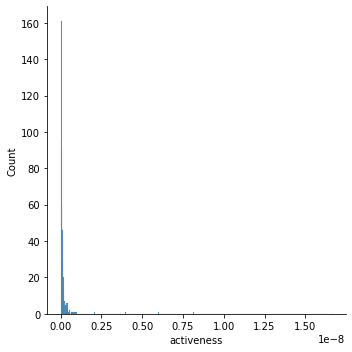

In [87]:
sns.displot(merged_df_adj, x="activeness")

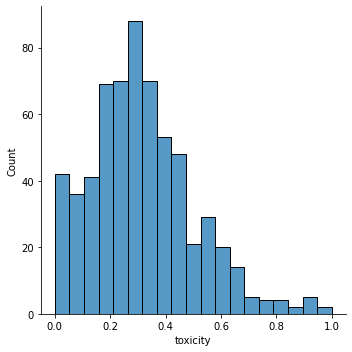

In [88]:
sns.displot(merged_df_adj, x="toxicity")

<AxesSubplot:xlabel='activeness', ylabel='toxicity'>

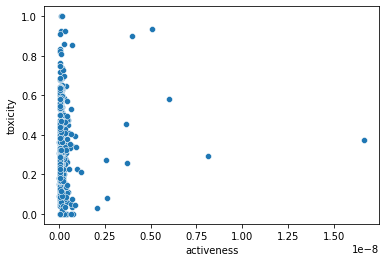

In [92]:
sns.scatterplot(data=merged_df_adj[merged_df_adj["activeness"] < 0.251e8], x="activeness", y="toxicity")